# Vietnam Rice Sims Paper - Maps 🗺

**NOTE**:
- final plots cells are marked and exported to dedicated `dvc` plotting stage and can be run programtically

In [123]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
import matplotlib
import proplot as plot
import xarray as xr
import geopandas as gpd
import pandas as pd
import cartopy
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature

from dataclasses import dataclass

from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False



from pathlib import Path
from typing import Union, Tuple

print("Versions of core DS packages:")
for x in [cartopy, plot, xr, gpd, pd]:
    print(f"    {x.__name__:10s}: {x.__version__}")

Versions of core DS packages:
    cartopy   : 0.20.3
    proplot   : 0.9.5
    xarray    : 2022.3.0
    geopandas : 0.11.0
    pandas    : 1.4.3


In [125]:
# if on mac enable retina plots
#%config InlineBackend.figure_format = 'retina'
#matplotlib.rcParams['figure.figsize'] = (13,8)
#plot.rc.inlineformat = 'retina'


In [126]:
from subprocess import check_output, CalledProcessError
from functools import lru_cache

@lru_cache(maxsize=1)
def root():
    ''' returns the absolute path of the repository root '''
    try:
        base = check_output('git rev-parse --show-toplevel', shell=True)
    except CalledProcessError:
        raise IOError('Current working directory is not a git repository')
    return Path(base.decode('utf-8').strip())

In [127]:
# parameters
inpath = root() / "data" / "raw"
outpath = root() / "data" / "analysis" / "plots"

In [128]:
outpath.mkdir(exist_ok=True)

# Helper functions


In [129]:
def plot_pdf_png(fig, name:str, out_path:Path=outpath, dpi:int=300):
    """ write plots as png and pdf """
    fig.save(out_path / (name + '.png'), dpi=dpi, transparent=False)
    fig.save(out_path / (name + '.pdf'))

def rt(x):
    """ reverse a tuple """
    return tuple(reversed(x))

## Load source data

### Auxillary data

In [130]:
# read admin shapefile
df_region = gpd.read_file(inpath / "misc" / "VN_regions3.zip")
df_provinces = gpd.read_file(inpath / "misc" / "VN_provinces3.zip")

features_region = ShapelyFeature(df_region.geometry, ccrs.PlateCarree(), facecolor='none')
features_province = ShapelyFeature(df_provinces.geometry, ccrs.PlateCarree(), facecolor='none')

In [131]:
# read netcdfs
misc = xr.open_dataset(inpath / "misc" / "VN_MISC5_V3.nc")
#annual = xr.open_dataset("../data/intermediate/annual_pctl.nc")
#seasonal = xr.open_dataset("../data/intermediate/seasonal_pctl.nc")

## Plot base maps

In [132]:
# annotate regions

# extra stuff for admin panel [label positions]
Dreg = [dict([('n','Mekong River'), ('a',(9.4, 106.125)), ('b', (-0.5, 2))]),
        dict([('n','North-East'), ('a',(22.,106.625)), ('b', (.25, 1.5))]),
        dict([('n','South-East'), ('a', (11.625,105.95)), ('b', (0.5,-1.5))]),
        dict([('n','Red River'), ('a', (20.3,106.55)), ('b', (-1.,1.5))]),
        dict([('n','North-C. Coast'), ('a', (17.9,105.625)), ('b', (-1., -1.5))]),
        dict([('n','South-C. Coast'), ('a', (15.3,108.875)), ('b', (2., -0.5))]),
        dict([('n','North-West'), ('a', (20.8,103.3)), ('b', (-1,-0.1))]),
        dict([('n','Central Highl.'), ('a', (12.95,107.55)), ('b', (0.5, -2.))])]

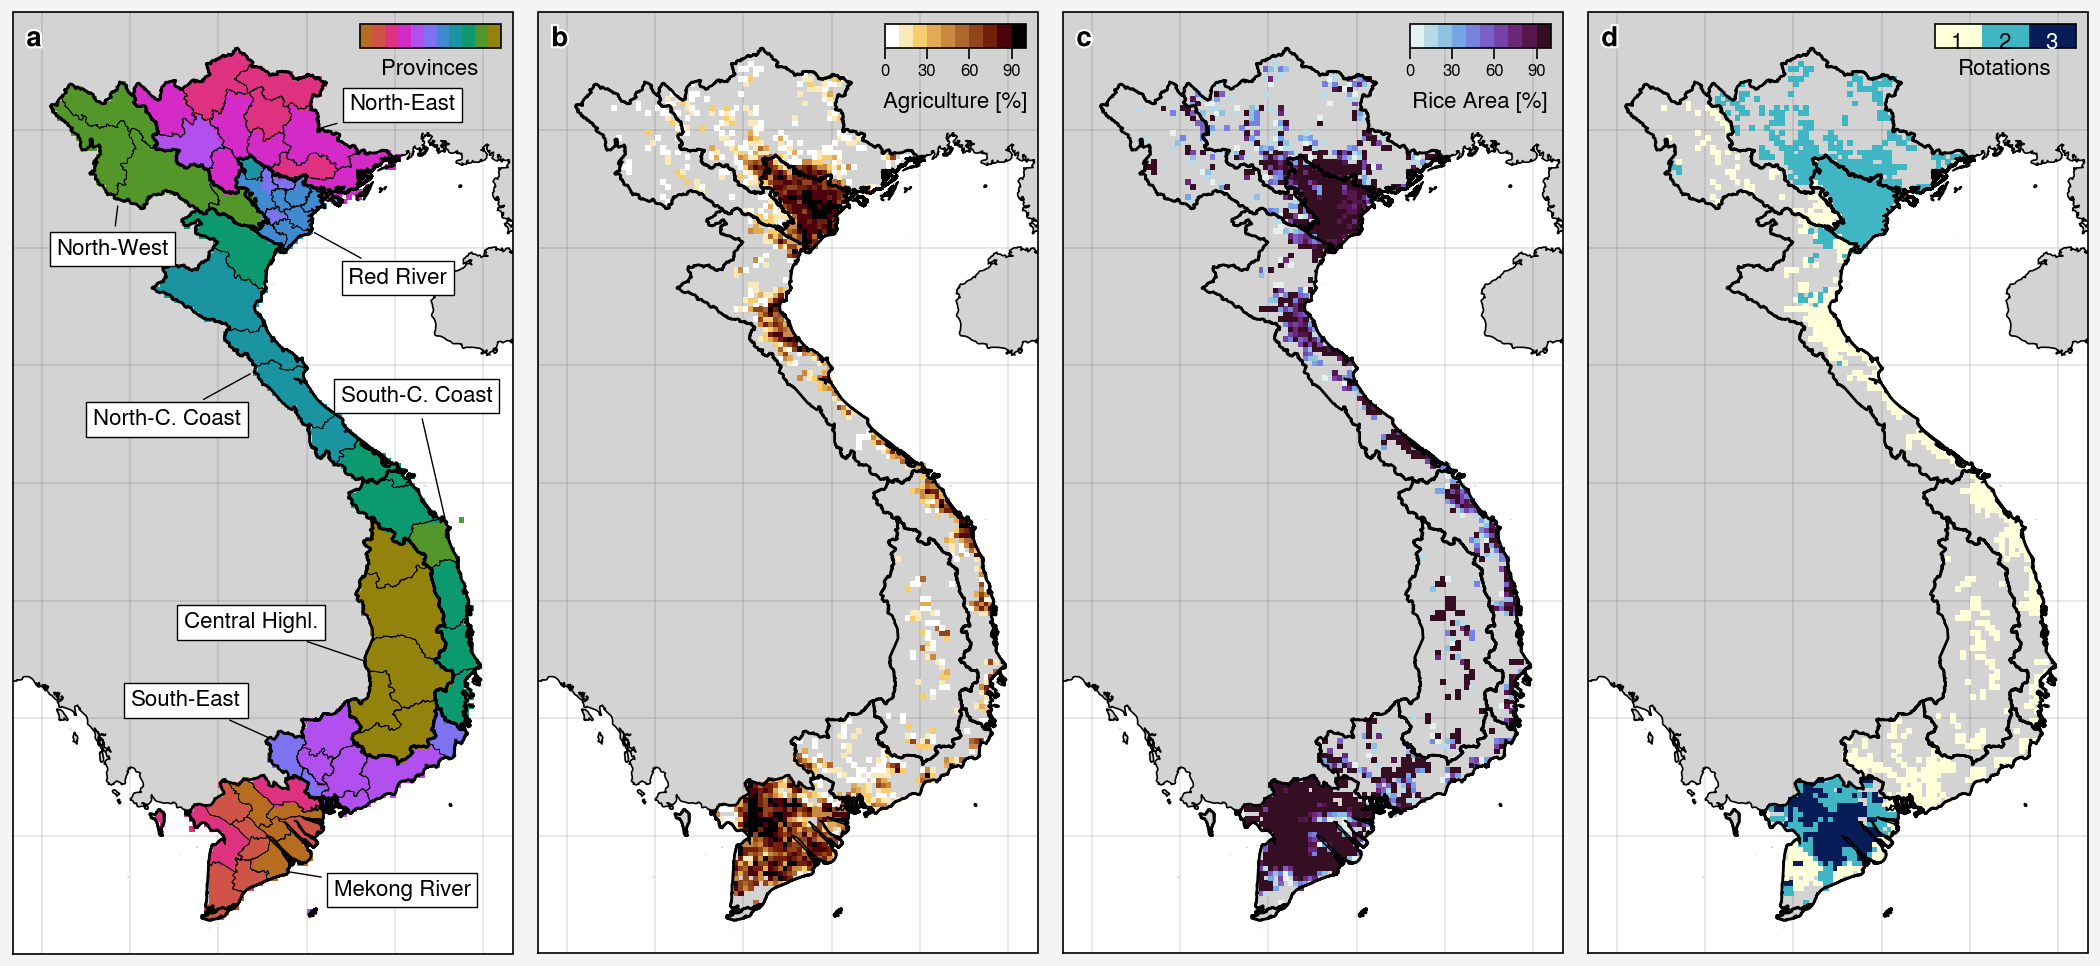

In [133]:
#import matplotlib.patheffects as PathEffects
import copy

def annotate_regions(ax):
    # TODO: figure out why this can onyl run once?!?
    transform = ccrs.PlateCarree()._as_mpl_transform(ax)
 
    for r in range(8):
        Dreg[r]['b'] = (Dreg[r]['a'][0] + Dreg[r]['b'][0], 
                        Dreg[r]['a'][1] + Dreg[r]['b'][1])
       
        ax.annotate(
            Dreg[r]['n'],
            xy=rt(Dreg[r]['a']), 
            xycoords=transform,
            xytext=rt(Dreg[r]['b']),
            size=8, va="bottom", ha="center", color='black',
            bbox=dict(boxstyle="square", fc='white', ec="black", lw=.5),
            arrowprops=dict(arrowstyle="-", fc="black", lw=.5),
            zorder=30,
        )


fig, axs = plot.subplots(ncols=4, nrows=1, proj='cyl')
axs.format(
    land=True,
    reso='hi',
    landcolor='lightgray',
    latlim=(8,24),
    lonlim=(101.5,110),
    abc=True, abcloc='ul', 
)


# -- 0 --
m = axs[0].pcolormesh(misc.provinceid, cmap='Phase', zorder=10)
axs[0].coastlines(zorder=20)
cb = axs[0].colorbar(m, loc='ur', pad='.25em', label='Provinces', width=0.5, length=3, frameon=False, labelsize=8) #Adding colorbar with label
cb.ax.get_xaxis().set_ticks([])
cb.ax.tick_params(labelsize=6)

annotate_regions(axs[0])

axs[0].add_geometries(df_provinces.geometry, fc="None", ec="black", crs=ccrs.PlateCarree(), lw=0.3, zorder=20)
axs[0].add_geometries(df_region.geometry, fc="None", ec="black", crs=ccrs.PlateCarree(), lw=1, zorder=21)

# axs[0].plot(cities.lon, cities.lat, 'r*', mec='k', ms=12, transform=ccrs.PlateCarree(), zorder=25)
# axs[0].text(cities.lon+.375, cities.lat+.375, cities.city_name, color='k', size=12, ha='left', va='center', 
#             transform=ccrs.PlateCarree(), 
#             path_effects=[PathEffects.withStroke(linewidth=2, foreground="w", alpha=1)], zorder=40)

# -- 1 --
m = axs[1].pcolormesh(misc.agrifrac.where(misc.rice_rot>0), cmap='Stellar', zorder=10)
axs[1].coastlines(zorder=20)
axs[1].add_geometries(df_region.geometry, fc="None", ec="black", crs=ccrs.PlateCarree(), lw=1, zorder=21)
cb = axs[1].colorbar(m, loc='ur', pad='.25em', label='Agriculture [%]', width=0.5, length=3, frameon=False, labelsize=8) #Adding colorbar with label
cb.ax.tick_params(labelsize=6)

# -- 2 --
m = axs[2].pcolormesh(misc.rice_fr.where(misc.rice_rot > 0), cmap='Dense', zorder=10)
axs[2].coastlines(zorder=20)
axs[2].add_geometries(df_region.geometry, fc="None", ec="black", crs=ccrs.PlateCarree(), lw=1, zorder=21)
cb = axs[2].colorbar(m, loc='ur', pad='.25em', label='Rice Area [%]', width=0.5,  length=3, frameon=False, labelsize=8) #Adding colorbar with label
cb.ax.tick_params(labelsize=6)

# -- 3 --
m = axs[3].pcolormesh(misc.rice_rot.where(misc.rice_rot > 0), levels=[0, 1, 2, 3], cmap='YlGnBu', zorder=10)
axs[3].coastlines(zorder=20)
axs[3].add_geometries(df_region.geometry, fc="None", ec="black", crs=ccrs.PlateCarree(), lw=1, zorder=21)
cb = axs[3].colorbar(m, loc='ur', pad='.25em', label='Rotations', width=0.5,  length=3, frameon=False, labelsize=8) #Adding colorbar with label
cb.ax.get_xaxis().set_ticks([])
cb.ax.tick_params(labelsize=6)

for j in range(0, 3, 1):
    c = 'white' if j == 2 else 'black'
    cb.ax.text((j+.35) , 0.5, j+1, ha='left', va='center', color=c, fontsize=8)
cb.ax.get_yaxis().labelpad = 5


plot_pdf_png(fig, 'management')

# Plot results maps

In [134]:
# read netcdfs
annual = xr.open_dataset(inpath / ".." / "intermediate" / "annual_pctl.nc")
seasonal = xr.open_dataset(inpath / ".." / "intermediate" / "seasonal_pctl.nc")

In [135]:
# da_ch4 = (annual.dC_ch4_emis * days_da).mean(dim='year')
# da_n2o = (annual.dN_n2o_emis * days_da).mean(dim='year')
da_ch4 = annual.dC_ch4_emis.mean(dim='year') * 10_000
da_n2o = annual.dN_n2o_emis.mean(dim='year') * 10_000

da_gwp    = (da_ch4 * 28 * (16./12.) + da_n2o * 298 * (44./28.)) * 0.001
da_yscale = ((da_ch4 * 28 * (16./12.) + da_n2o * 298 * (44./28.)) / 
            ((annual.DW_fru_export * 10_000).mean(dim='year') * 0.001))



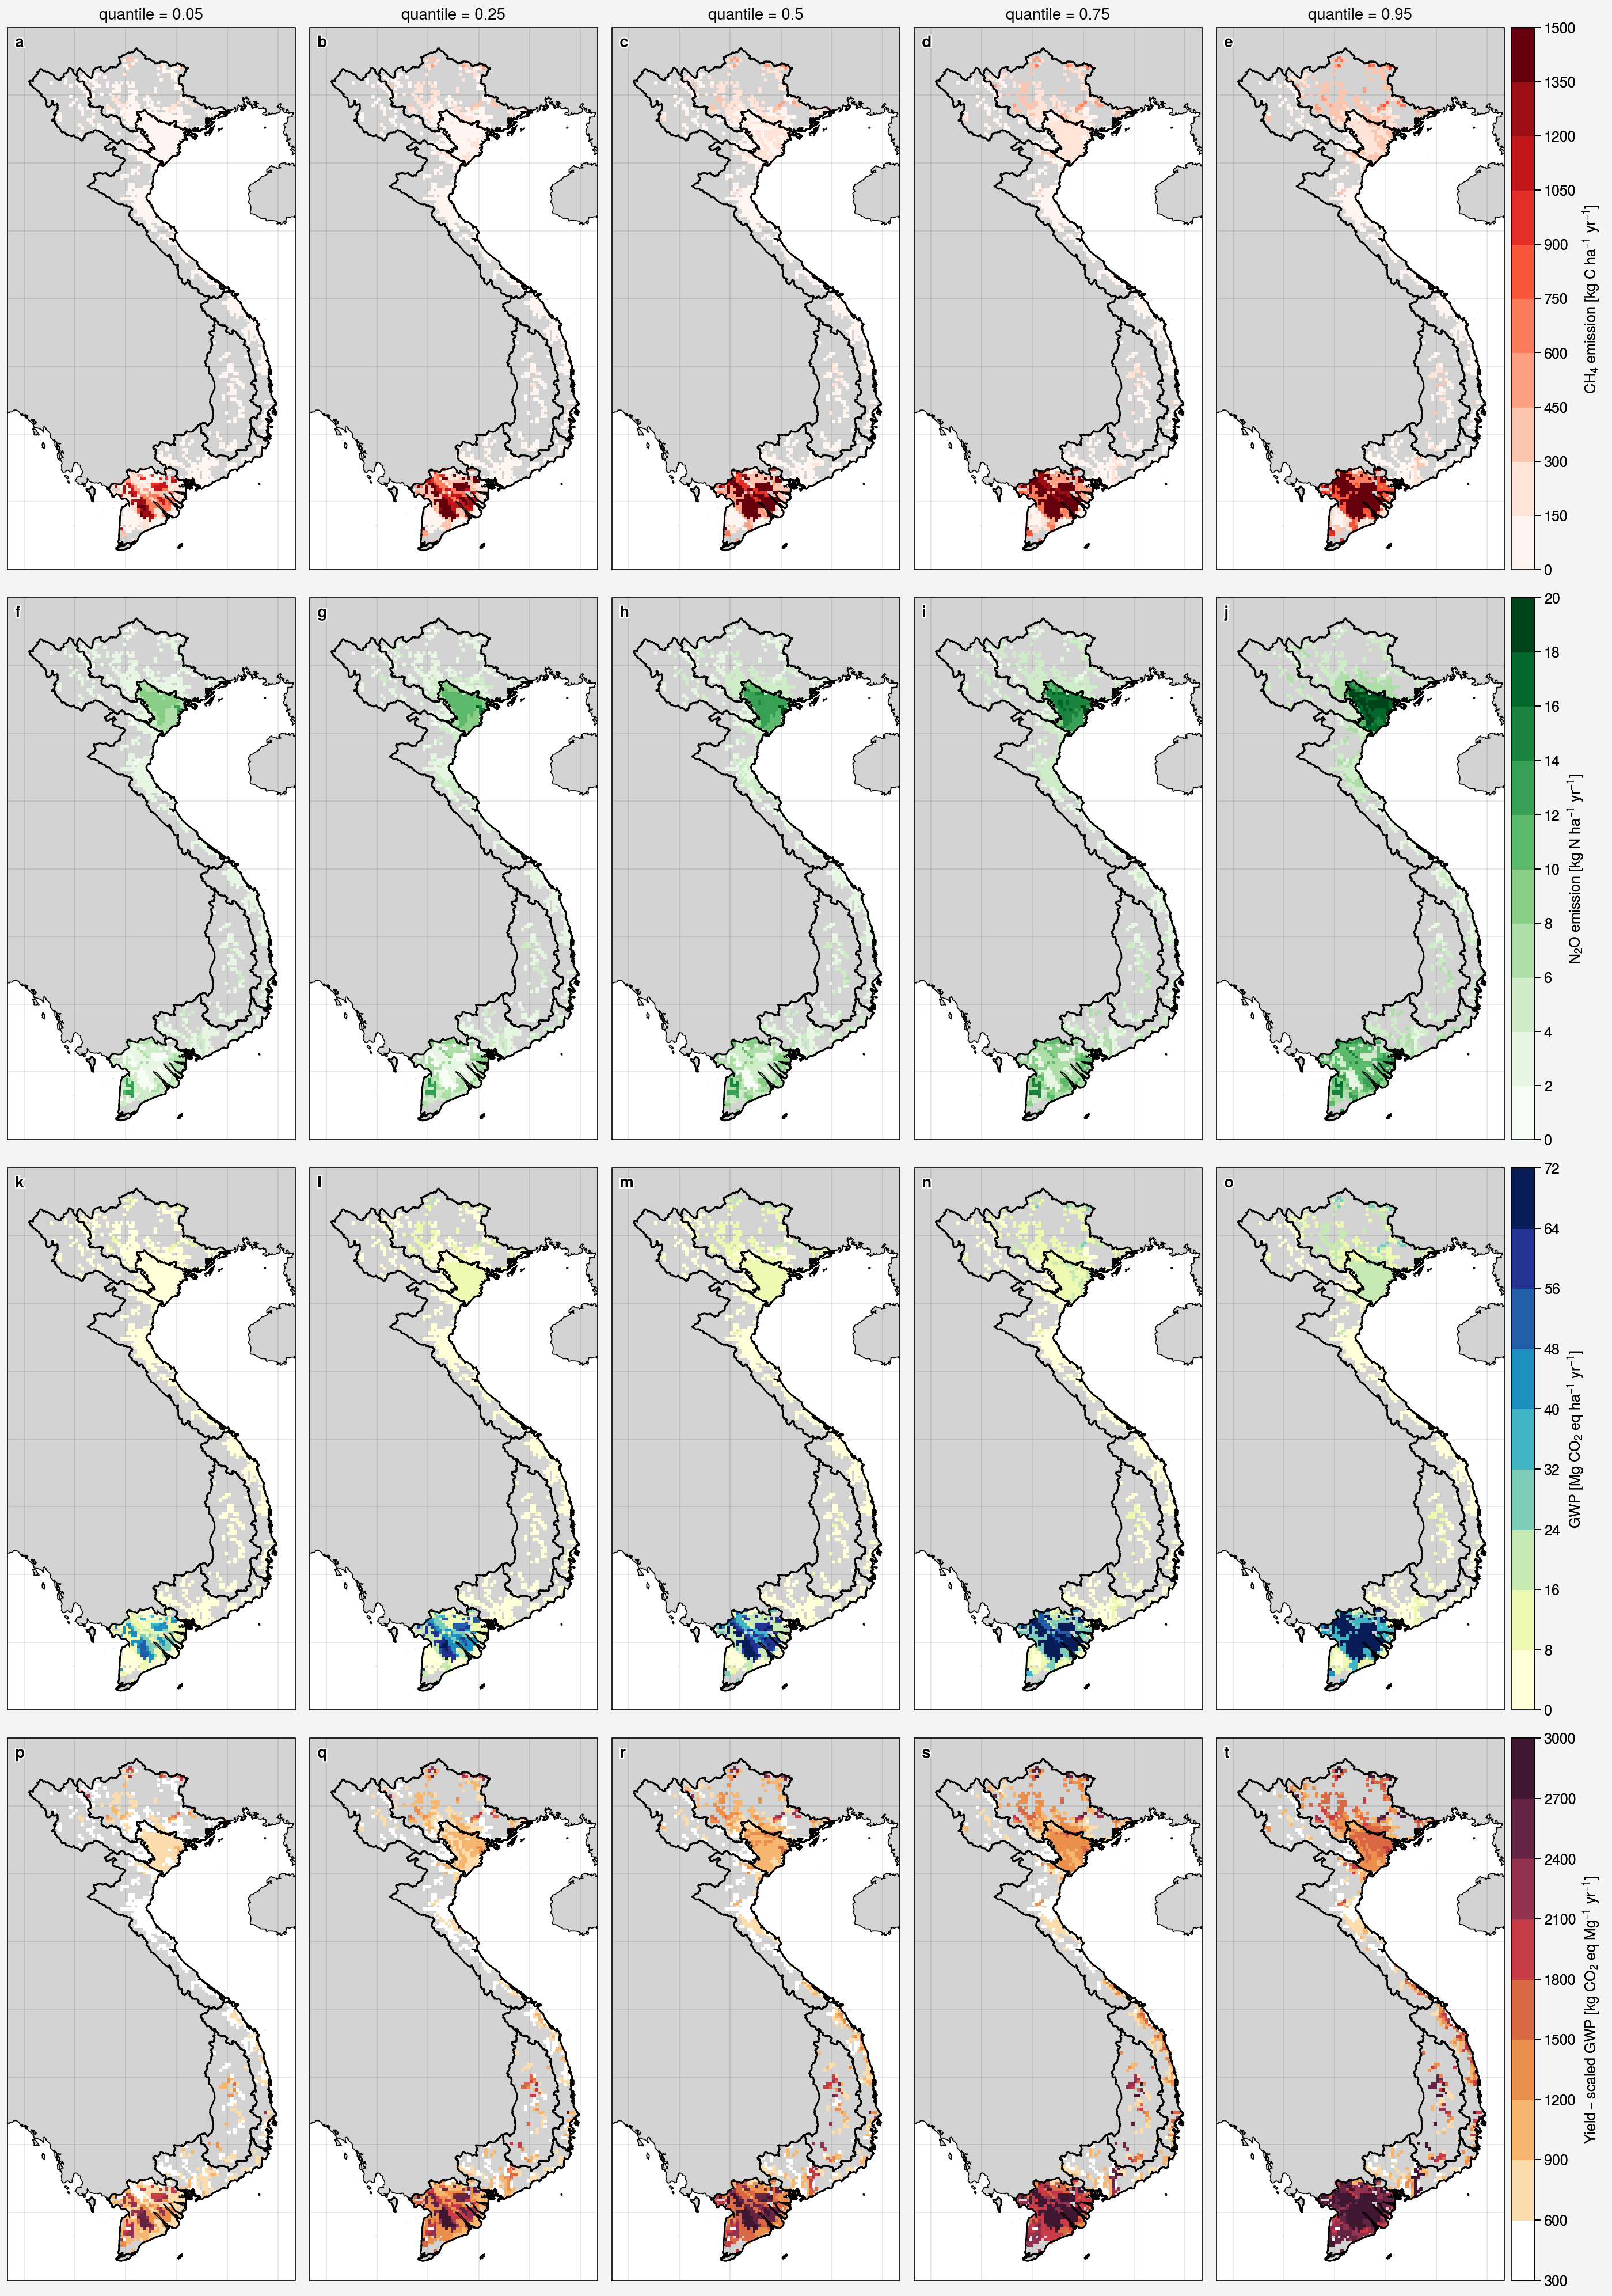

In [136]:
fig, axs = plot.subplots(ncols=5, nrows=4, proj='cyl')
axs.format(
    land=True,
    reso='hi',
    landcolor='lightgray',
    latlim=(8,24),
    lonlim=(101.5,110),
    abc=True, abcloc='ul', 
)

for i, ax in enumerate(axs[:5]):
    p=da_ch4.isel(quantile=i).plot(
        ax=ax, 
        vmin=0, vmax=1500, 
        cmap='Reds', 
        transform=ccrs.PlateCarree(), 
        zorder=20,
        extend='max',
        #label="label" if i == 4 else None,
        add_colorbar=False #True if i == 4 else False
    )
    if i == 4: ax.colorbar(p, label=r"$\mathregular{CH_4\ emission\ [kg\ C\ ha^{-1}\ yr^{-1}]}$")


for i, ax in enumerate(axs[5:10]):
    p=da_n2o.isel(quantile=i, drop=True).plot(
        ax=ax, 
        vmin=0, vmax=20, 
        cmap='Greens', 
        transform=ccrs.PlateCarree(), 
        zorder=20,
        extend='max',
        #label="label" if i == 4 else None,
        add_colorbar=False #True if i == 4 else False
    )
    if i == 4: ax.colorbar(p, label=r"$\mathregular{N_2O\ emission\ [kg\ N\ ha^{-1}\ yr^{-1}]}$")


for i, ax in enumerate(axs[10:15]):
    p=da_gwp.isel(quantile=i, drop=True).plot(
        ax=ax, 
        vmin=0, vmax=75, 
        cmap='YlGnBu', 
        transform=ccrs.PlateCarree(), 
        zorder=20,
        extend='max',
        #label="label" if i == 4 else None,
        add_colorbar=False #True if i == 4 else False
    )
    if i == 4: ax.colorbar(p, label=r"$\mathregular{GWP\ [Mg\ CO_2\ eq\ ha^{-1}\ yr^{-1}]}$")

    
for i, ax in enumerate(axs[15:20]):
    p=da_yscale.isel(quantile=i, drop=True).plot(
        ax=ax, 
        vmin=150, vmax=3000, 
        cmap='Fire', 
        transform=ccrs.PlateCarree(), 
        zorder=20,
        extend='max',
        #label="label" if i == 4 else None,
        add_colorbar=False #True if i == 4 else False
    )
    if i == 4: ax.colorbar(p, label=r"$\mathregular{Yield-scaled\ GWP\ [kg\ CO_2\ eq\ Mg^{-1}\ yr^{-1}]}$")

   
    
for i, ax in enumerate(axs):
    ax.coastlines(zorder=21)
    ax.add_geometries(df_region.geometry, fc="None", ec="black", crs=ccrs.PlateCarree(), lw=1, zorder=22)

plot_pdf_png(fig, "emissions")    

# Plot temporal/ seasonal emissions

In [137]:
@dataclass
class Data:
    dates: pd.DataFrame
    emissions: pd.DataFrame
    auxillary: pd.DataFrame

@dataclass
class Selection:
    seltype: str
    value: Union[str, Tuple[float]]

# Mekong, single site
def prepare_data(selection:Selection) -> Data:
    if selection.seltype == 'latlon':
        LAT, LON = selection.value
    elif selection.seltype == 'region':
        if selection.value not in ['mekong', 'redriver']:
            raise NotImplementedError

    REGIONID = {'mekong': 1, 'redriver': 4}.get(selection.value, None)
    
    ds = seasonal[['dN_n2o_emis', 'dC_ch4_emis']] * 10_000
    ds2 = seasonal[['DW_above', 'surfacewater']]

    if REGIONID:
        df = ds.where(misc.regionid == REGIONID).mean(dim=['lat', 'lon']).to_dataframe()
        df2 = ds2.where(misc.regionid == REGIONID).mean(dim=['lat', 'lon']).to_dataframe()
    else:
        df = ds.sel(lon=LON, lat=LAT, method='nearest').to_dataframe()
        df2 = ds2.sel(lon=LON, lat=LAT, method='nearest').to_dataframe()
    
    df = df.reset_index().pivot(index='dayofyear', columns='quantile', values=['dN_n2o_emis', 'dC_ch4_emis'])
    df.columns = [f"{x[0]}_{str(x[1])}".replace(".","").replace("_05","_050") for x in df.columns]

    df2 = df2.reset_index().pivot(index='dayofyear', columns='quantile', values=['DW_above', 'surfacewater'])
    df2.columns = [f"{x[0]}_{str(x[1])}".replace(".","").replace("_05","_050") for x in df2.columns]

    dates = pd.date_range('2000-01-01', '2000-12-31', freq='D')
    return Data(dates, df, df2)



In [138]:
def create_seasonal_plot(*, title:str, data:Data, filename:str):
    """ --- """

    # scale co2 and n2o to appropriate ylims
    gwp_factor = 28*(16/12) / 298*(44/28)
    
    fig, axs = plot.subplots(ncols=1, nrows=3, hratios=[2.5,1,1], sharex=True, spany=False, aligny=True, figsize=(14,6))

    axs[0].format(ylabel='CH$_4$ emission\n[kg C ha$^{-1}$]', ylim=(0,8))
    ax0r = axs[0].alty(loc='right', ylabel='N$_2$O emissions [kg N ha$^{-1}$]')
    ax0r.format(ylim=(0,8*gwp_factor))

    a1 = axs[0].area(data.dates, data.emissions.dC_ch4_emis_005, data.emissions.dC_ch4_emis_095, color='orange', labels="P$_5$-P$_{95}$", alpha=.5)
    a2 = axs[0].area(data.dates, data.emissions.dC_ch4_emis_025, data.emissions.dC_ch4_emis_075, color='red', labels="P$_{25}$-P$_{75}$", alpha=.5)
    al = axs[0].line(data.dates, data.emissions.dC_ch4_emis_050, color='black', labels="Median")
    axs[0].set_title(title)

    b1 = ax0r.area(data.dates, data.emissions.dN_n2o_emis_005, data.emissions.dN_n2o_emis_095, color='lightgreen', labels="P$_5$-P$_{95}$", alpha=.5)
    b2 = ax0r.area(data.dates, data.emissions.dN_n2o_emis_025, data.emissions.dN_n2o_emis_075, color='green', labels="P$_{25}$-P$_{75}$", alpha=.5)
    bl = ax0r.line(data.dates, data.emissions.dN_n2o_emis_050, color='black', labels="Median", linestyle="dashed")

    axs[1].area(data.dates, data.auxillary.surfacewater_005*0.01, data.auxillary.surfacewater_095*0.01, color='gray', label="P$_5$-P$_{95}$", alpha=.5)
    axs[1].area(data.dates, data.auxillary.surfacewater_025*0.01, data.auxillary.surfacewater_075*0.01, color='blue', label="P$_{25}$-P$_{75}$", alpha=.5)
    axs[1].line(data.dates, data.auxillary.surfacewater_050*0.01, color='black', labels="Median")

    axs[2].area(data.dates, data.auxillary.DW_above_005*10, data.auxillary.DW_above_095*10, color='gray', labels="P$_5$-P$_{95}$", alpha=.5)
    axs[2].area(data.dates, data.auxillary.DW_above_025*10, data.auxillary.DW_above_075*10, color='olive', labels="P$_{25}$-P$_{75}$", alpha=.5)
    axs[2].line(data.dates, data.auxillary.DW_above_050*10, color='black', labels="Median")

    axs[0].format(ylabel='CH$_4$ emission\n[kg C ha$^{-1}$]')
    axs[1].format(ylabel='Surface water\n[m]', ylim=(0, 1.75))
    axs[2].format(ylabel='Crop biomass\n[t DW ha$^{-1}$]')

    axs.format(
        abc=True, abcloc='ul',
        xlocator='month', 
        xtickminor=False, #'weekday', 
        xformatter='%b',
        xrotation='horizontal',
    )


    handle_a1 = PolyCollection([])
    handle_a1.update_from(a1)
    handle_a2 = PolyCollection([])
    handle_a2.update_from(a2)

    elements = [al[0], bl[0], a1, b1, a2, b2]
    labels = [r"$\mathbf{CH_4}$", r"$\mathbf{N_2O}$"] + [l.get_label() for l in elements]

    ph = [plt.plot([],marker="", ls="")[0]]*2
    elements  = ph + elements 

    axs[0].legend(elements, labels, loc='ur', ncol=2) #, facecolor='white')
    axs[1].legend(loc="ur", ncol=1)
    axs[2].legend(loc="ur", ncol=1)

    plot_pdf_png(fig, filename)    

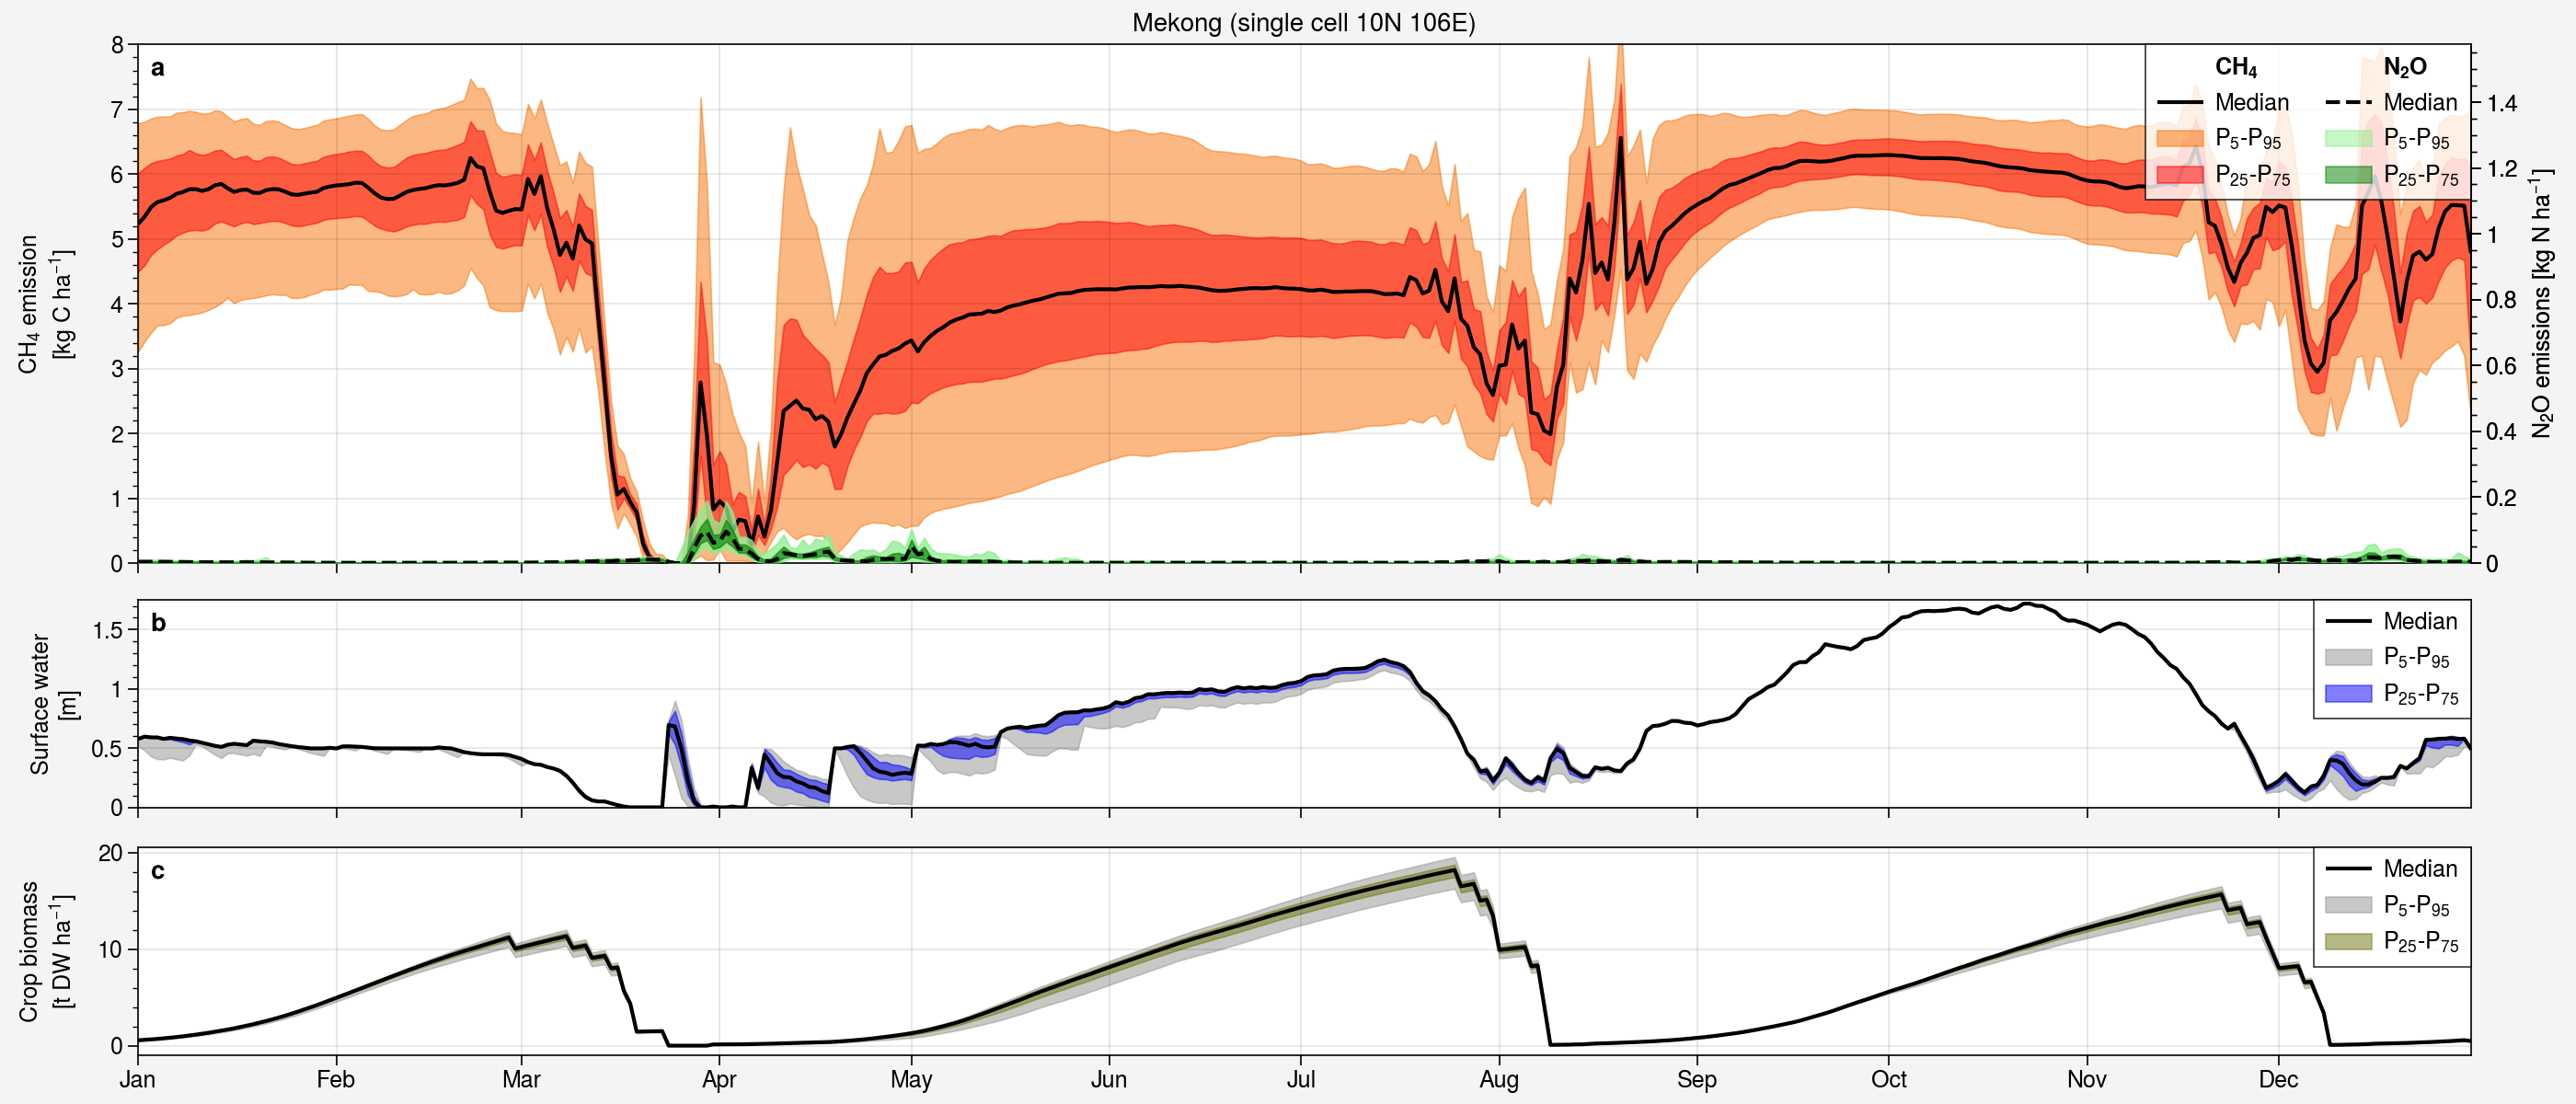

In [139]:
data = prepare_data(Selection('latlon', (10, 106)))  
create_seasonal_plot(title="Mekong (single cell 10N 106E)", data=data, filename="emissions_seasonal_location_mekong")

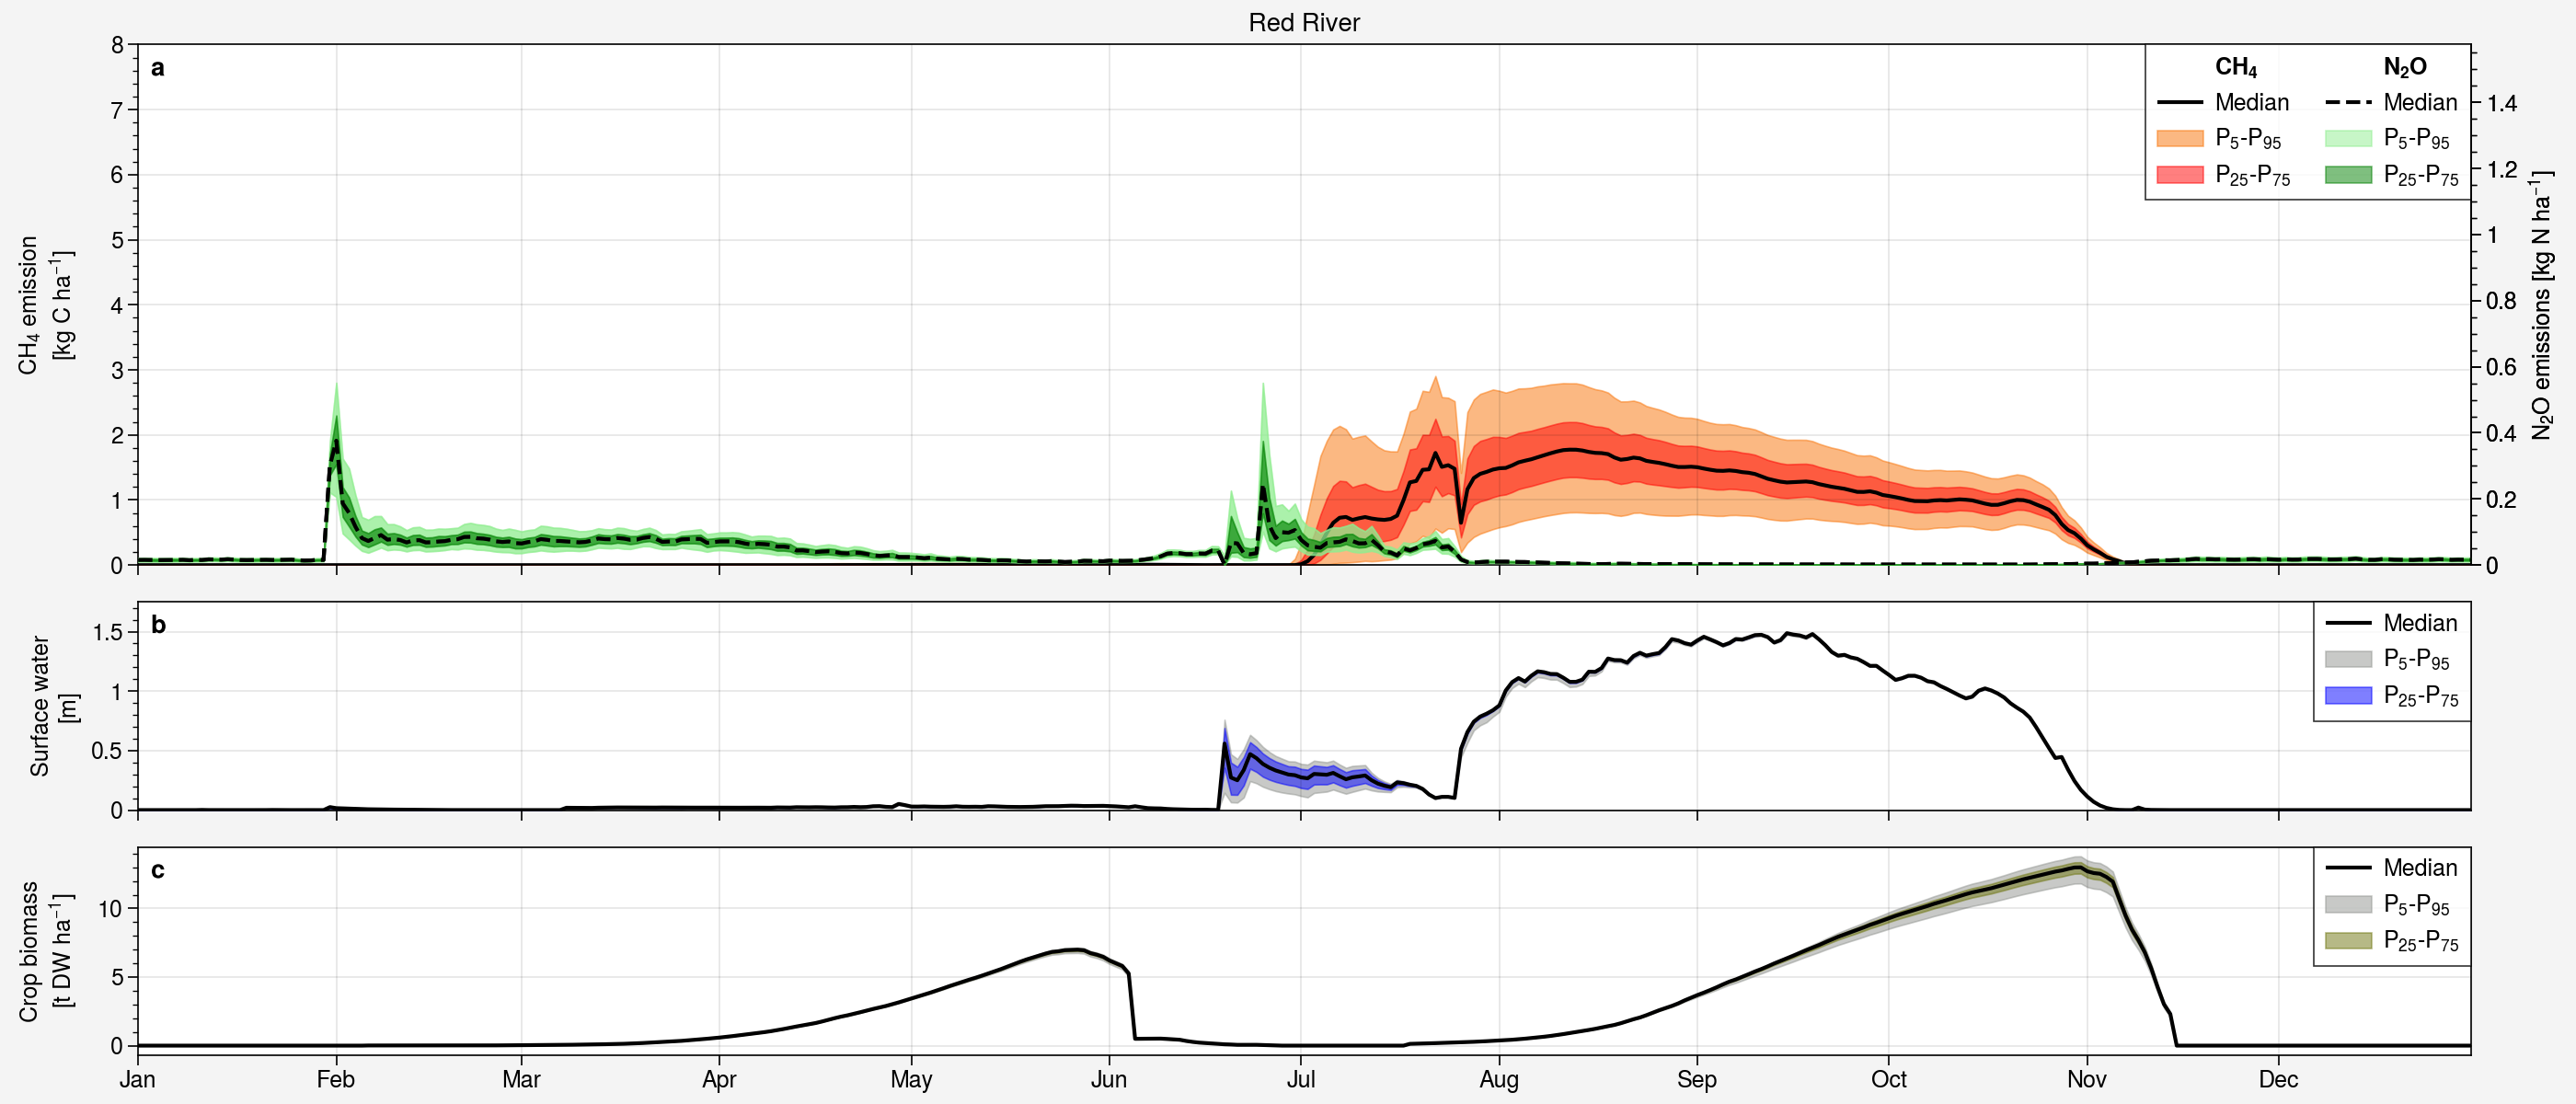

In [140]:
plt.rcParams['text.usetex'] = False

data = prepare_data(Selection('region', 'redriver'))
   
create_seasonal_plot(title="Red River", data=data, filename="emissions_seasonal_redriver")

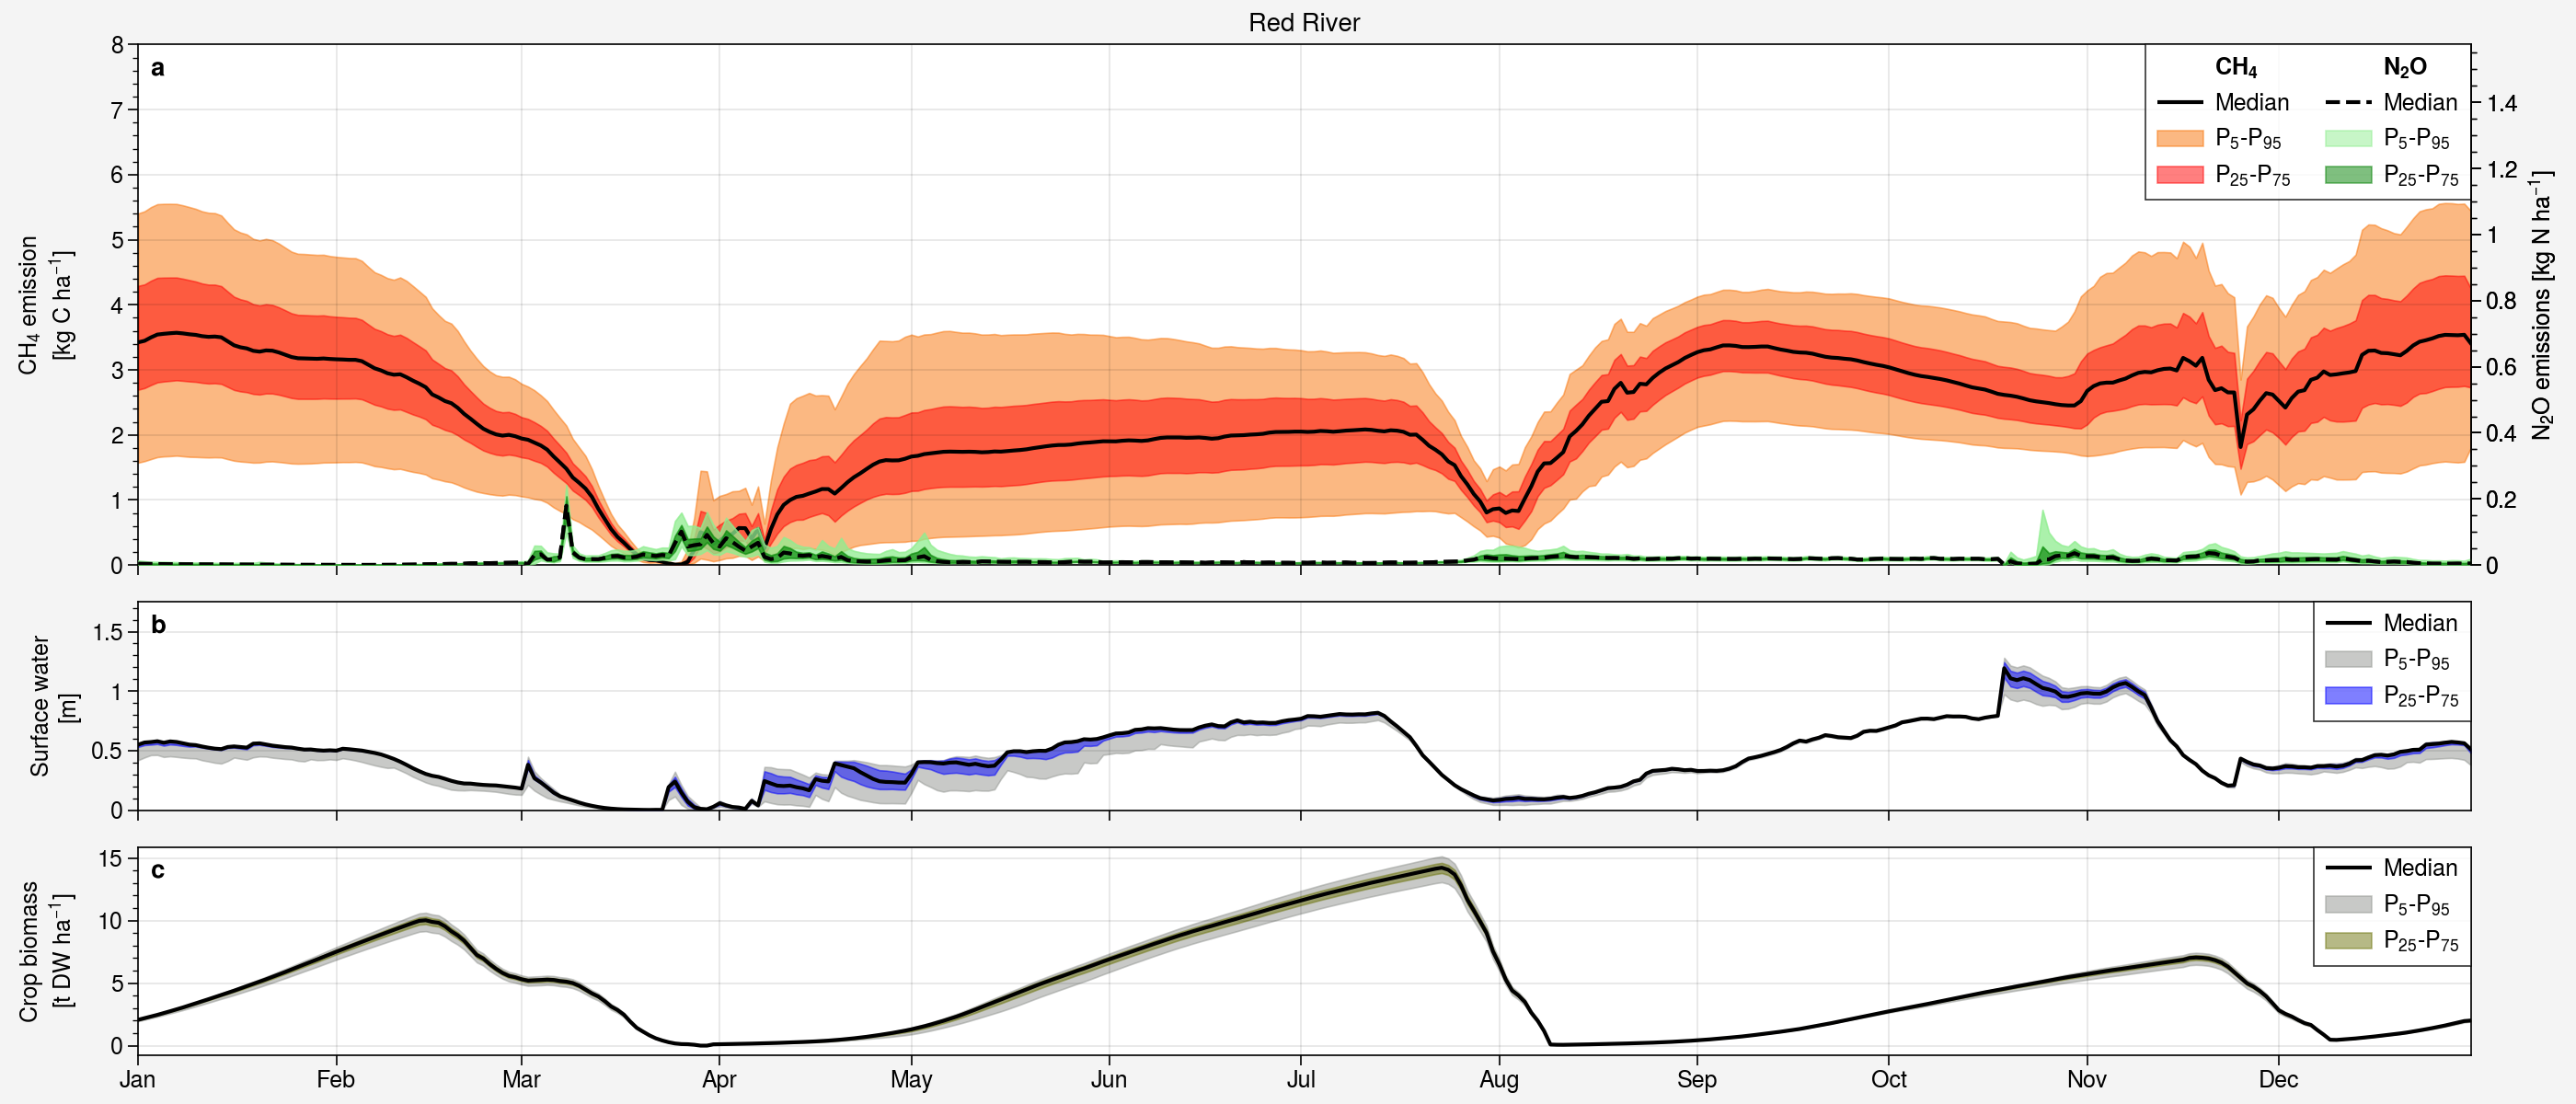

In [141]:
plt.rcParams['text.usetex'] = False

data = prepare_data(Selection('region', 'mekong'))
   
create_seasonal_plot(title="Mekong", data=data, filename="emissions_seasonal_mekong")